In [1]:
"""
AUTHOR: Shihao Zhang
Date: 10/24/2018

What is this script for?
This script can process raw data from ZenDesk by:
1. Train classifiers with labeled HVAC tickets
2. Classify tickets without label

How to use this script?
Prepare a excel file. Here is the preparation instruction:
1. 
2. The first column must be time stamp

Package required:
pandas, numpy, skilearn
"""

'\nAUTHOR: Shihao Zhang\nDate: 10/24/2018\n\nWhat is this script for?\nThis script can process raw data from ZenDesk by:\n1. Train classifiers with labeled HVAC tickets\n2. Classify tickets without label\n\nHow to use this script?\nPrepare a excel file. Here is the preparation instruction:\n1. \n2. The first column must be time stamp\n\nPackage required:\npandas, numpy, skilearn\n'

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
"""
USER INPUT
"""
path_train = "Tickets(SF02_2018Nov01).csv"
cols_train = [ "Created","Description","Label", "Label_id","Requester_Name"]

path_test = "GoldenGate_1st.csv"
cols_test = [ "Datetime","Requester Name","Requester Email", "Temp"]

In [3]:
"""
Dataset Preparation
"""

if __name__ == "__main__":
    # CSV file should be in ASCII encoding
    data = pd.read_csv(path_train,usecols=cols_train)

data.head()

Label_id_df = data[['Label', 'Label_id']].drop_duplicates().sort_values('Label_id')
Label_to_id = dict(Label_id_df.values)
id_to_Label = dict(Label_id_df[['Label_id', 'Label']].values)

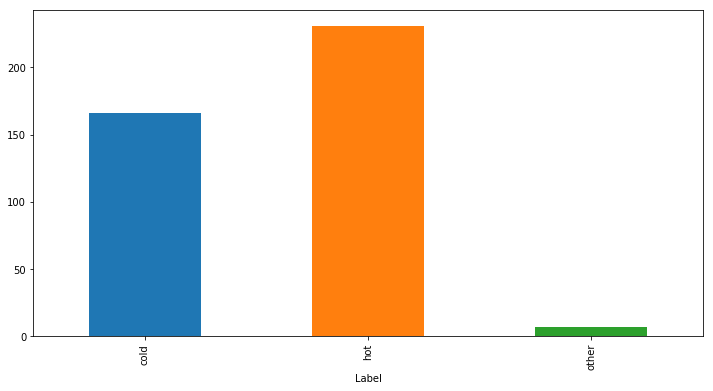

hot      231
cold     166
other      7
Name: Label, dtype: int64


In [18]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,6))
data.groupby('Label').Description.count().plot.bar(ylim=0)
plt.show()

print(data['Label'].value_counts())

In [5]:
"""
Feature Engineering
"""
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

C:\Users\szhang7\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [6]:
# Keep AC

ac_keywords = [" AC ", " ac ", "a/c", "A/C", "HVAC", "Hvac", "hvac ", "Air Condition", "Air condition", "air condition"]

def keep_ac(texts,ac_keywords):
    data_description = []
    for text in texts:
        for keyword in ac_keywords:        
            if keyword in text: # actually acceptable
                text = text.replace(keyword,"AC ")
        data_description.append(text)
    return data_description
            
data["Description"] = keep_ac(data["Description"], ac_keywords)

data["Description"][3]
    

"Hi, \nI think the air turned off in our office. It's becoming hot and humid again. Requesting a bit of AC ing. Many thanks!"

In [7]:
# bag of words
def sent_to_words(texts):
    for text in texts:
        yield(simple_preprocess(text, min_len=2))

data_words = list(sent_to_words(data["Description"]))
print (data_words[3])


# Preparing Stop Words
stop_words = stopwords.words('english')
stop_words.extend(["hi","hey","guys","you","thank","thanks","please","would","could"])
for w in ["on","off","up","down"]:
    stop_words.remove(w)

# Define functions process stopwords & other keywords
def remove_stopwords(texts):
    new_texts=[]
    for text in texts:
        yield([word for word in text if word not in stop_words])

# Remove Stop Words
data_words_nonstops = list(remove_stopwords(data_words))
print(data_words_nonstops[3])

['hi', 'think', 'the', 'air', 'turned', 'off', 'in', 'our', 'office', 'it', 'becoming', 'hot', 'and', 'humid', 'again', 'requesting', 'bit', 'of', 'ac', 'ing', 'many', 'thanks']
['think', 'air', 'turned', 'off', 'office', 'becoming', 'hot', 'humid', 'requesting', 'bit', 'ac', 'ing', 'many']


In [8]:
# Trigram
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, numpy, string

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2),stop_words=stop_words)
features = tfidf.fit_transform(data["Description"]).toarray()
labels = data.Label
features.shape

(404, 190)

In [9]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Label, Label_id in sorted(Label_to_id.items()):
  features_chi2 = chi2(features, labels == Label)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Label))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'cold':
  . Most correlated unigrams:
. cold
. freezing
  . Most correlated bigrams:
. heat 650
. on heat
# 'hot':
  . Most correlated unigrams:
. cold
. freezing
  . Most correlated bigrams:
. heat 650
. on heat
# 'other':
  . Most correlated unigrams:
. nice
. really
  . Most correlated bigrams:
. off office
. air off


In [10]:
"""
Model Buliding
"""


'\nModel Buliding\n'

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

C:\Users\szhang7\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\szhang7\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\szhang7\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\szhang7\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warni

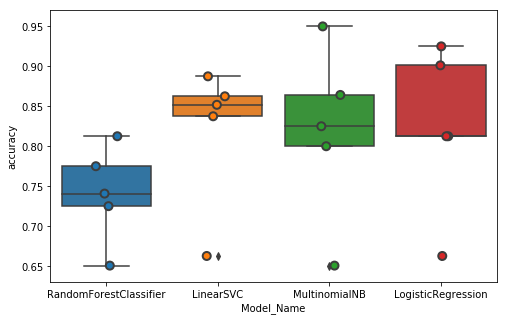

In [12]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  Model_Name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((Model_Name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['Model_Name', 'fold_idx', 'accuracy'])

import seaborn as sns
plt.subplots(figsize=(8,5))

sns.boxplot(x='Model_Name', y='accuracy', data=cv_df, width=0.8)
sns.stripplot(x='Model_Name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [13]:
cv_df.groupby('Model_Name').accuracy.mean()

Model_Name
LinearSVC                 0.820400
LogisticRegression        0.822777
MultinomialNB             0.817960
RandomForestClassifier    0.740769
Name: accuracy, dtype: float64

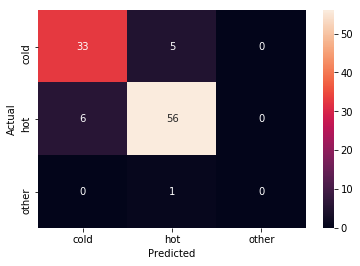

In [14]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.25, random_state=None)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=Label_id_df.Label.values, yticklabels=Label_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [15]:
table = {"cold":0, "hot":1, "other": 2}
table["cold"]

0

In [16]:
from IPython.display import display
for predicted in Label_id_df.Label:
  for actual in Label_id_df.Label:
        if predicted != actual and conf_mat[table[actual], table[predicted]] >= 1:
          print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[table[actual], table[predicted]]))
          display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Label', 'Description']])
          print('')

NameError: name 'id_to_category' is not defined

In [ ]:
# SVM
#
#